## **Quickstart Guide**

This guide covers the standard usage pattern and basic functionality to help you get started with twinLab. In this jupyter notebook we will:

1. Upload a dataset to twinLab.
2. Use `Emulator.train` to train a surrogate model.
3. Use the model to make a prediction with `Emulator.predict`.
4. Visualise the results and their uncertainty.


In [1]:
# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Project imports
import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.1.0
          Server      : https://mo1b0kfcp6.execute-api.eu-west-2.amazonaws.com/dev
          Environment : /Users/sergiochavez/twinlab-demos/.env



### **Your twinLab information**

Confirm your twinLab version


In [2]:
tl.versions()

{'cloud': '2.0.0',
 'modal': '0.2.0',
 'library': '1.4.0',
 'image': 'twinlab-sergio'}

And view your user information, including how many credits you have.


In [3]:
tl.user_information()

{'username': 'sergio', 'credits': 0}

### **Upload a dataset**

Datasets must be data presented as a `pandas.DataFrame` object, or a filepaths which points to a csv file that can be parsed to a `pandas.DataFrame` object. **Both must be formatted with clearly labelled columns.** Here, we will label the input (predictor) variable `x` and the output variable `y`. In `twinlab`, data is expected to be in column-feature format, meaning each row represents a single data sample, and each column represents a data feature.

`twinLab` contains a `Dataset` class with attirbutes and methods to process, view and summarise the dataset. Datasets must be created with a `dataset_id` which is used to access them. The dataset can be uploaded using the `upload` method.


In [4]:
x = [
    0.6964691855978616,
    0.28613933495037946,
    0.2268514535642031,
    0.5513147690828912,
    0.7194689697855631,
    0.42310646012446096,
    0.9807641983846155,
    0.6848297385848633,
    0.48093190148436094,
    0.3921175181941505,
]

y = [
    -0.8173739564129022,
    0.8876561174050408,
    0.921552660721474,
    -0.3263338765412979,
    -0.8325176123242133,
    0.4006686354731812,
    -0.16496626502368078,
    -0.9607643657025954,
    0.3401149876855609,
    0.8457949914442409,
]

# Creating the dataframe using the above arrays
df = pd.DataFrame({"x": x, "y": y})

# View the dataset before uploading
display(df)

# Define the name of the dataset
dataset_id = "example_data"

# Intialise a Dataset object
dataset = tl.Dataset(id=dataset_id)

# Upload the dataset
dataset.upload(df, verbose=True)

,x,y
0,0.696469,-0.817374
1,0.286139,0.887656
2,0.226851,0.921553
3,0.551315,-0.326334
4,0.719469,-0.832518
5,0.423106,0.400669
6,0.980764,-0.164966
7,0.684830,-0.960764
8,0.480932,0.340115
9,0.392118,0.845795


Dataframe is uploading.
Processing dataset
Dataset example_data was processed.


### **Train an emulator**

The `Emulator` class is used to train and implement your surrogate models. As with datasets, an id is defined, this is what the model will be saved as in the cloud. When training a model the arguments are passed using a `TrainParams` object; `TrainParams` is a class that contains all the necessary parameters needed to train your model. To train the model we use the `Emulator.train` function, inputting the `TrainParams` object as an argument to this function.


In [5]:
# Initialise emulator
emulator_id = "example_emulator"

emulator = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
params = tl.TrainParams(train_test_ratio=1.0)

# Train the mulator using the train method
emulator.train(
    dataset=dataset, inputs=["x"], outputs=["y"], params=params, verbose=True
)

Internal server error
Training complete!


### **Prediction using the trained emulators**

The surrogate model is now trained and saved to the cloud under the `emulator_id`. It can now be used to make predictions. First define a dataset of inputs for which you want to find outputs; ensure that this is a `pandas.DataFrame` object. Then call `Emulator.predict` with the keyword arguments being the evaluation dataset.


In [6]:
# Define the inputs for the dataset
x_eval = np.linspace(0, 1, 128)

# Convert to a dataframe
df_eval = pd.DataFrame({"x": x_eval})
display(df_eval)

# Predict the results
predictions = emulator.predict(df_eval)
result_df = pd.concat([predictions[0], predictions[1]], axis=1)
df_mean, df_stdev = result_df.iloc[:, 0], result_df.iloc[:, 1]
df_mean, df_stdev = df_mean.values, df_stdev.values
print(result_df.head())

,x
0,0.000000
1,0.007874
2,0.015748
3,0.023622
4,0.031496
...,...
123,0.968504
124,0.976378
125,0.984252
126,0.992126


          y         y
0  0.618116  0.653885
1  0.629521  0.638148
2  0.641034  0.621944
3  0.652643  0.605284
4  0.664334  0.588181


### **Viewing the results**

`Emulator.predict` outputs mean values for each input and their standard deviation; this gives the abilty to nicely visualise the uncertainty in results.


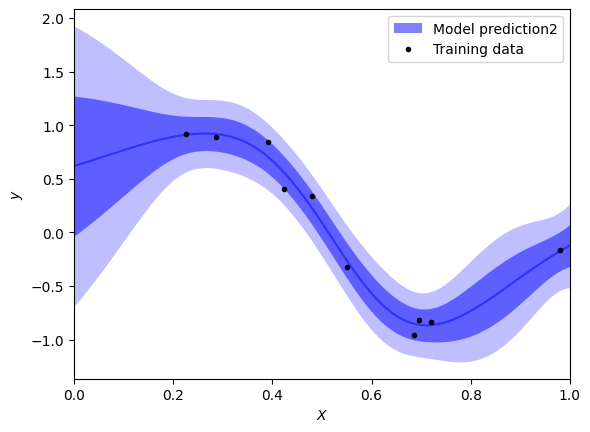

In [7]:
# Plot parameters
nsigs = [1, 2]
# nsigs = [0.674, 1.960, 2.576]
color = "blue"
alpha = 0.5
plot_training_data = True
plot_model_mean = True
plot_model_bands = True

# Plot results
grid = df_eval["x"]
mean = df_mean
err = df_stdev
if plot_model_bands:
    label = r"Model prediction"
    plt.fill_between(grid, np.nan, np.nan, lw=0, color=color, alpha=alpha, label=label)
    for isig, nsig in enumerate(nsigs):
        plt.fill_between(
            grid,
            mean - nsig * err,
            mean + nsig * err,
            lw=0,
            color=color,
            alpha=alpha / (isig + 1),
        )
if plot_model_mean:
    label = r"Model prediction" if not plot_model_bands else None
    plt.plot(grid, mean, color=color, alpha=alpha, label=label)
if plot_training_data:
    plt.plot(df["x"], df["y"], ".", color="black", label="Training data")
plt.xlim((0.0, 1.0))
plt.xlabel(r"$X$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()

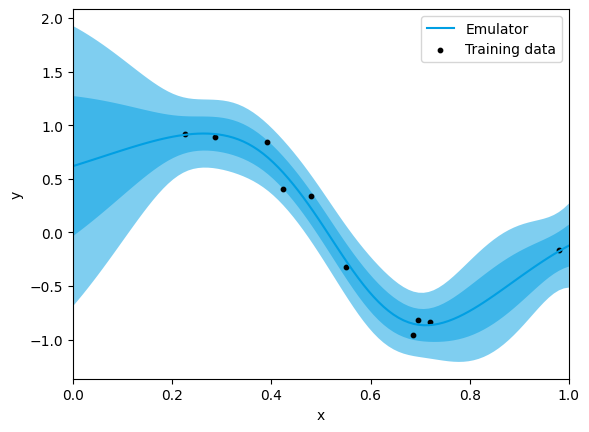

In [12]:
#Plot results
plt=emulator.plot(
    x_axis="x",
    y_axis="y",
    x_lim=(0, 1.0),
)
plt.scatter(df["x"], df["y"], color="black", label="Training data", s=10,alpha=1)
plt.legend()
plt.show()

### **Deleteing datasets and campaigns**

To keep your cloud storage tidy you should delete your datasets and emulators when you are finished with them. `Emulator.delete` and `Dataset.delete` deletes the emulators and the datasets from the cloud storage respectively.


In [9]:
# # Delete dataset
# dataset.delete()

# # Delete campaign
# emulator.delete()